## Préparation du notebook

## chargement librairies

In [2]:
import pandas as pd


In [3]:
# import librairies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score

from scipy import stats
import warnings


In [4]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [5]:
warnings.filterwarnings("ignore")

## chargement jeu de données

In [6]:
# Chargement des données avec pandas
data = pd.read_csv('billets.csv', sep=';')

In [7]:
print(data.shape)

(1500, 7)


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [9]:
data.head(2)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09


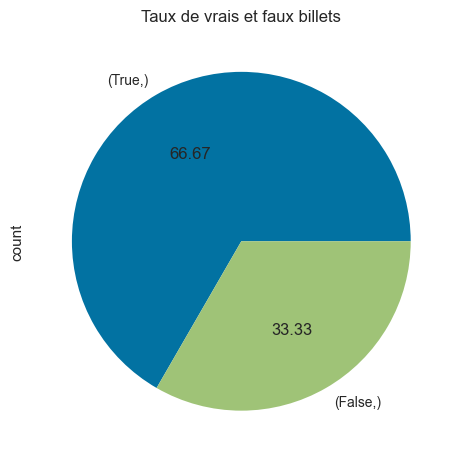

In [10]:
# On affiche le taux de vrais et faux billets du df avec la variable "is_genuine"
data[['is_genuine']].value_counts().plot.pie(autopct='%.2f')
plt.title('Taux de vrais et faux billets')
plt.show()

# Préparation des données

## Data cleaning (manquantes, aberrantes, extrêmes)

In [11]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
diagonal,1500.0,171.958440,0.305195,171.04,171.750,171.96,172.17,173.01
height_left,1500.0,104.029533,0.299462,103.14,103.820,104.04,104.23,104.88
height_right,1500.0,103.920307,0.325627,102.82,103.710,103.92,104.15,104.95
margin_low,1463.0,4.485967,0.663813,2.98,4.015,4.31,4.87,6.90
margin_up,1500.0,3.151473,0.231813,2.27,2.990,3.14,3.31,3.91
length,1500.0,112.678500,0.872730,109.49,112.030,112.96,113.34,114.44


### Manquantes

In [12]:
pd.isnull(data).sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

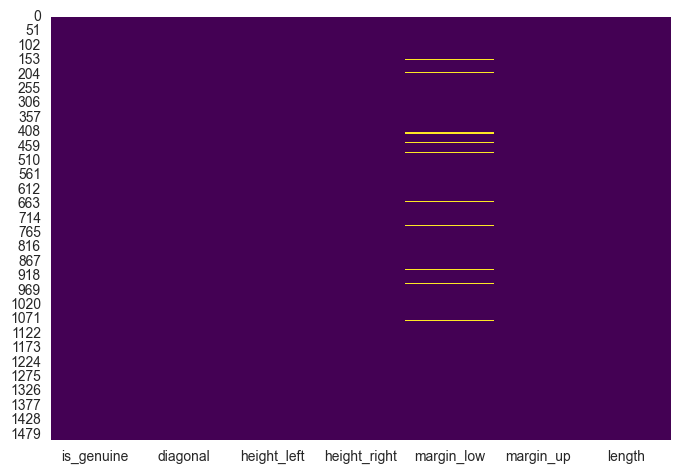

In [13]:
import seaborn as sns

import matplotlib.pyplot as plt

# nous definissons la couleur 
color = 'viridis' 

# visualisons à travers un heatmap
sns.heatmap(data.isnull(), cmap = color, cbar = False)

plt.show()

In [14]:
data.corr()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.132756,-0.379833,-0.485092,-0.783032,-0.606262,0.849285
diagonal,0.132756,1.000000,0.019472,-0.024492,-0.111534,-0.055649,0.097587
height_left,-0.379833,0.019472,1.000000,0.242279,0.302643,0.246522,-0.320863
height_right,-0.485092,-0.024492,0.242279,1.000000,0.391085,0.307005,-0.401751
margin_low,-0.783032,-0.111534,0.302643,0.391085,1.000000,0.431606,-0.666753
margin_up,-0.606262,-0.055649,0.246522,0.307005,0.431606,1.000000,-0.520575
length,0.849285,0.097587,-0.320863,-0.401751,-0.666753,-0.520575,1.000000


<Axes: >

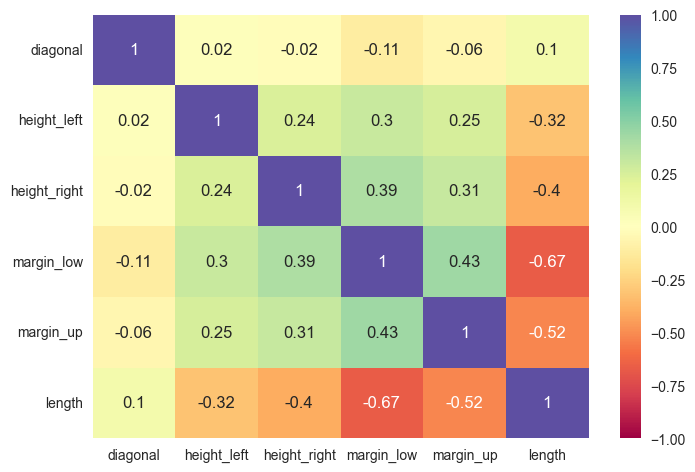

In [15]:
# Matrice de corrélation
correlation_matrix = data[["diagonal","height_left","height_right","margin_low","margin_up","length"]].corr().round(2)

sns.heatmap(correlation_matrix,annot=True, cmap='Spectral', vmin=-1, vmax=1)

**Remarques :**
> 
> Les plus fortes corrélations sont :
> * positive entre la longueur et l'authenticité du billet
> * négative entre la marge du bas et l'authenticité du billet

## Régression linéaire pour valeurs manquantes

Les valeurs manquantes appartiennent toutes à une variable dépendante continue : on peut calculer les valeurs avec une régression linéaire.

In [16]:
data.sample(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
165,True,171.81,103.53,103.76,3.91,2.87,113.52
171,True,172.40,103.51,103.52,3.68,3.16,113.35
1258,False,172.42,103.69,104.29,5.25,3.33,110.70
125,True,171.50,104.03,103.97,3.26,3.54,113.24
280,True,171.85,103.64,103.63,3.73,3.29,112.95


In [17]:
# On prépare les données
df = data.copy()

# On convertit les bool en int
df["is_genuine"] = df["is_genuine"].astype(int)

In [18]:
# on recupere lignes nan sur 'df_na'
df_na = df[df["margin_low"].isnull()]

# suppression des nan de 'df'
df.dropna(inplace=True)

In [19]:
pd.isnull(df).sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1463 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1463 non-null   int64  
 1   diagonal      1463 non-null   float64
 2   height_left   1463 non-null   float64
 3   height_right  1463 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1463 non-null   float64
 6   length        1463 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 91.4 KB


### Recherche modèle avec le meilleur r2

In [21]:
# Choix du model de régression
y = df["margin_low"]

X = df[["margin_up", "is_genuine"]]

# Splitting the data into train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, SGDRegressor
from time import time
from sklearn import metrics
regressors = [LinearRegression(), Lasso()]

In [23]:
head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", metrics.explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", metrics.mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", metrics.r2_score(y_test, y_pred))
    print()

LinearRegression()
	Training time: 0.042s
	Prediction time: 0.016s
	Explained variance: 0.6743376377018512
	Mean absolute error: 0.2897307135185014
	R2 score: 0.6736214684077528

Lasso()
	Training time: 0.000s
	Prediction time: 0.000s
	Explained variance: 0.0
	Mean absolute error: 0.5212680493567866
	R2 score: -8.248054288073625e-05



### Optimisation linear regression

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Define the pipeline
pipeline = Pipeline([('scaler', StandardScaler()), ("estimator", LinearRegression())])

# Define the parameters to search
params = {}  # No regularization parameters for Linear Regression

# Define the grid search
model_linear = GridSearchCV(pipeline, param_grid=params, cv=5)
model_linear.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('estimator', LinearRegression())]),
             param_grid={})

In [25]:
model_linear_opti = model_linear.best_estimator_

model_linear_opti.score(X_test, y_test)

0.6736214684077528

In [26]:
# prediction des nan avec la linear regression
predict_na = model_linear_opti.predict(df_na[["margin_up", "is_genuine"]])

### Validation de la régression linéaire

* Test de Variance Inflation Factor (VIF) pour détecter la collinéarité

In [27]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ajouter une constante de statsmodels
X_train_const = sm.add_constant(X_train)

# Calcul du VIF pour chaque variable
vif_data = pd.DataFrame()
vif_data["Feature"] = ["const"] + [f"X{i}" for i in range(X_train.shape[1])]
vif_data["VIF"] = [variance_inflation_factor(X_train_const, i) for i in range(X_train_const.shape[1])]

print(vif_data)


  Feature         VIF
0   const  338.926386
1      X0    1.640983
2      X1    1.640983


>**Remarque :**
>
>Le VIF de 1.64 pour X0 et X1 est faible (inférieurs à 5) c'est-à-dire que les variables explicatives ne sont pas fortement corrélées entre elles et donc il n'y a pas de problème de multicollinéarité dans le modèle. 

* Test de normalité des résidus

Statistique de Shapiro-Wilk: 0.9468961546990912, p-value: 8.544017469861416e-09


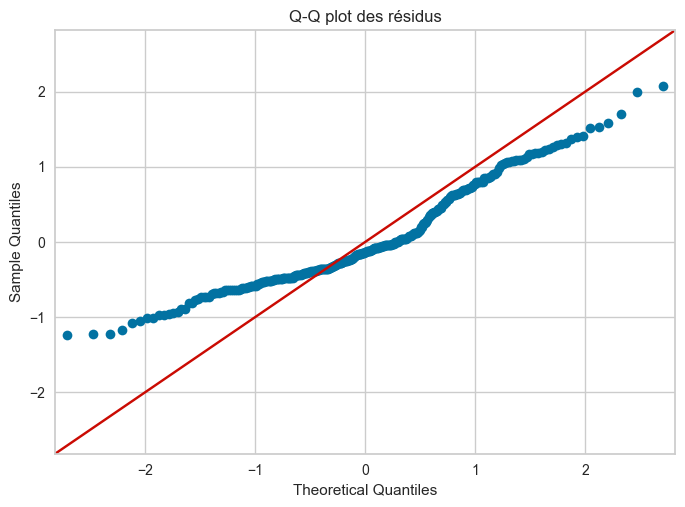

In [28]:
# Calcul des résidus
residuals = y_test - y_pred

# Test de normalité de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)
print(f"Statistique de Shapiro-Wilk: {shapiro_test[0]}, p-value: {shapiro_test[1]}")

# Q-Q plot des résidus
sm.qqplot(residuals, line ='45')
plt.title("Q-Q plot des résidus")
plt.show()

La p-value est bien inférieure à 0.05, ce qui signifie qu'on peut rejeter l'hypothèse nulle selon laquelle les résidus suivent une distribution normale.

Cela indique donc que les résidus ne sont pas normalement distribués

* Test de l'homoscédasticité

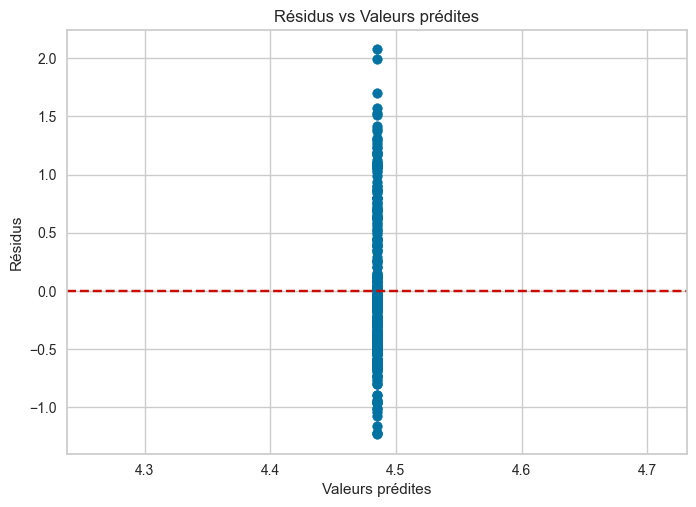

In [29]:
# Graphique des résidus vs valeurs prédites
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Résidus vs Valeurs prédites")
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.show()

Le graphique montre que les valeurs prédites sont presque toutes concentrées autour de 4.5, ce qui indique un manque de variabilité dans les prédictions du modèle.

Cela suggère que le modèle sous-apprend et ne capture pas bien les relations entre les variables.

Il pourrait être nécessaire d'utiliser un modèle plus complexe ou d'ajouter des variables explicatives pour améliorer la performance du modèle.


### Imputation des NaN avec la linear regression

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [31]:
data["margin_low"][data["margin_low"].isnull()] = predict_na

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


# Analyse Univariée du jeu de données

In [33]:
features = data[['diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length']]

target = data[['is_genuine']]

## analyse des features

Variable  diagonal  



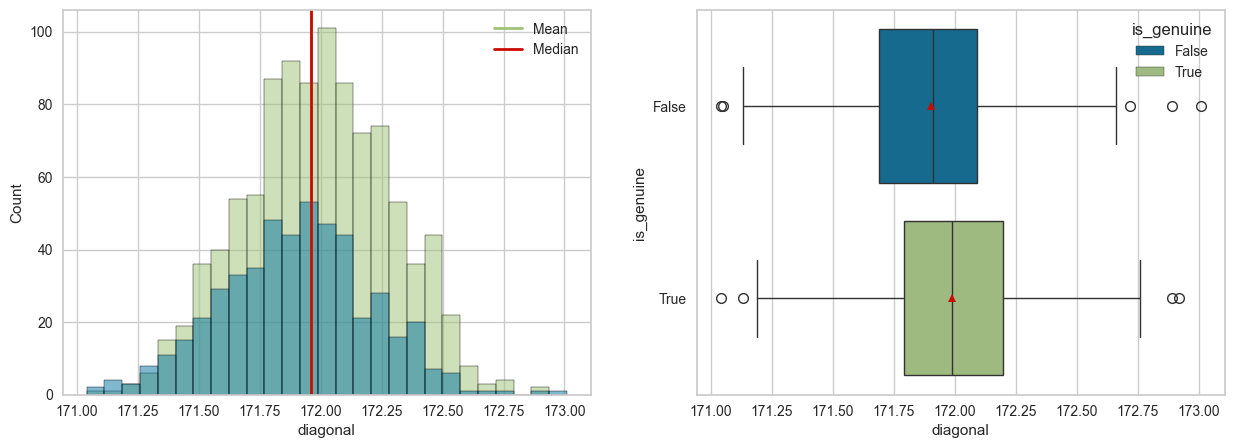

 Moyenne :  171.96
 Médiane :  171.96
 Kurtosis :  -0.13
 Écart-type :  0.31

 ************************************************** 

Variable  height_left  



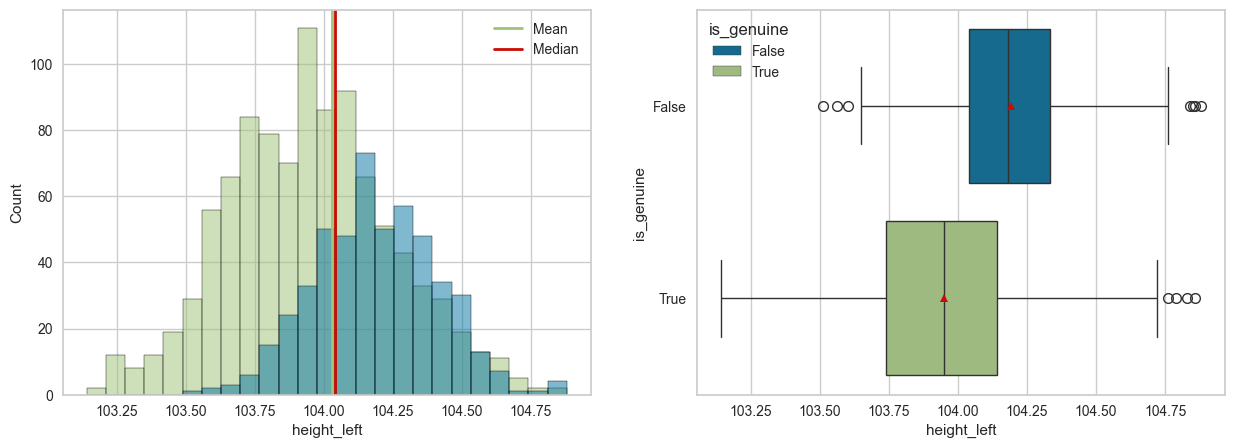

 Moyenne :  104.03
 Médiane :  104.04
 Kurtosis :  -0.2
 Écart-type :  0.3

 ************************************************** 

Variable  height_right  



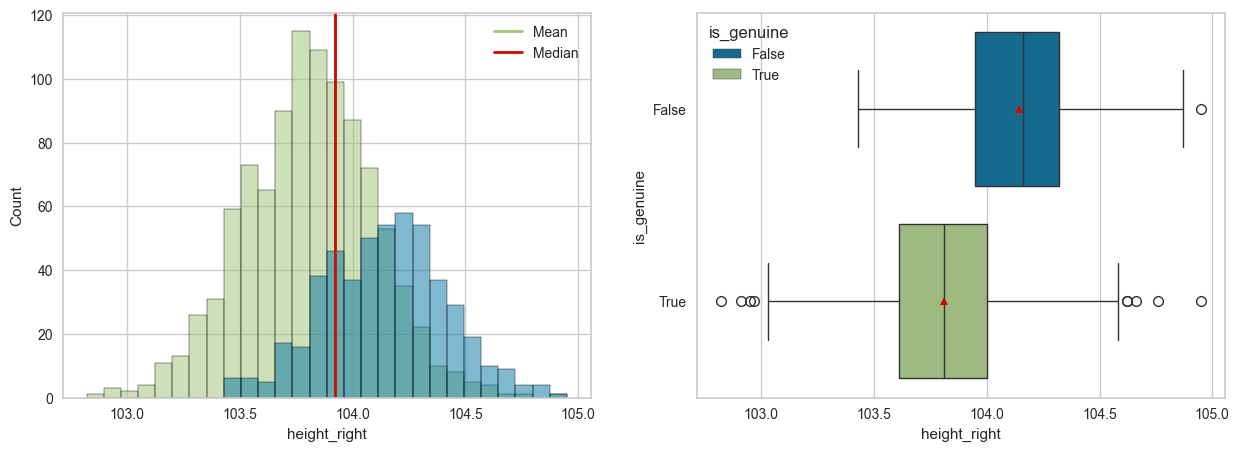

 Moyenne :  103.92
 Médiane :  103.92
 Kurtosis :  -0.03
 Écart-type :  0.33

 ************************************************** 

Variable  margin_low  



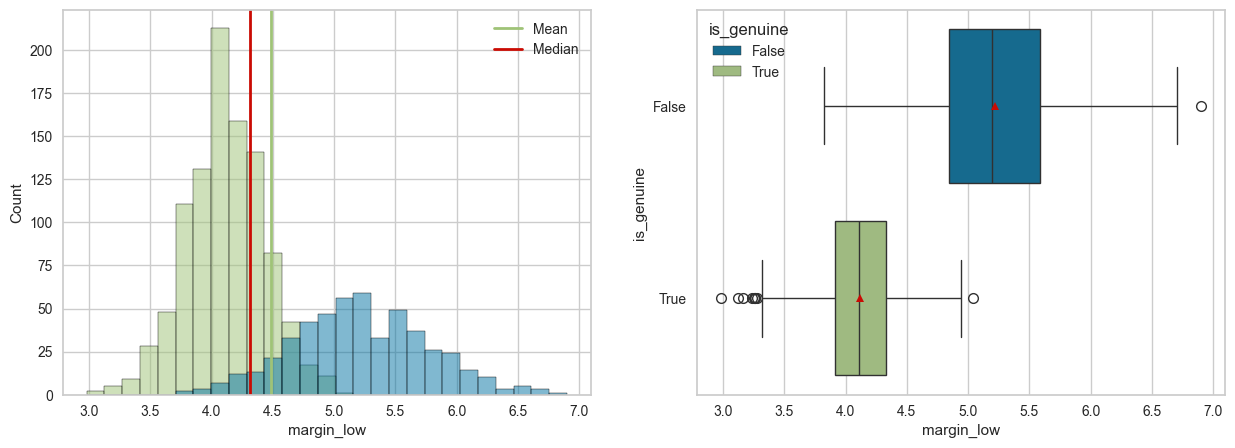

 Moyenne :  4.48
 Médiane :  4.31
 Kurtosis :  0.25
 Écart-type :  0.66

 ************************************************** 

Variable  margin_up  



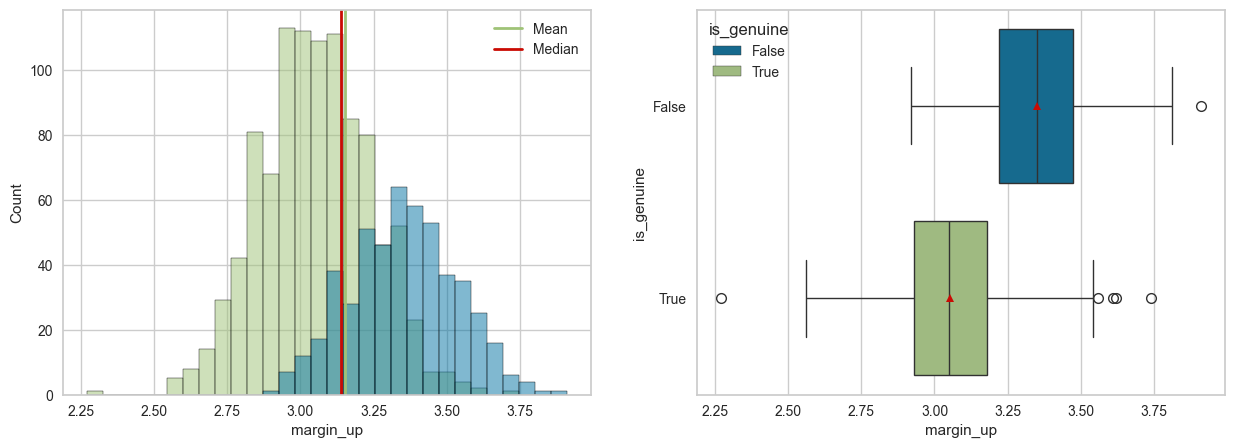

 Moyenne :  3.15
 Médiane :  3.14
 Kurtosis :  -0.25
 Écart-type :  0.23

 ************************************************** 

Variable  length  



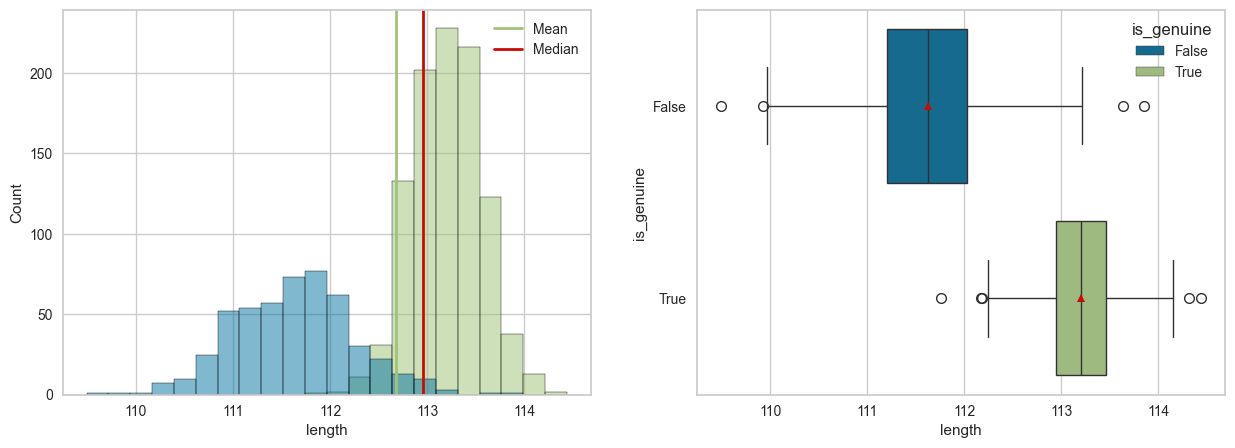

 Moyenne :  112.68
 Médiane :  112.96
 Kurtosis :  -0.28
 Écart-type :  0.87

 ************************************************** 



In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define feature and target names
features_names = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
target_name = 'is_genuine'

# Iterate over each feature
for var in features_names:
    print("Variable", '\033[1m', var, '\033[0m', "\n")
    
    plt.figure(figsize=(15, 5))
    
    # Plot histogram with KDE
    plt.subplot(121)
    sns.histplot(data=data, x=var, hue=target_name, legend=False)
    plt.axvline(data[var].mean(), color='g', linewidth=2, label='Mean')
    plt.axvline(data[var].median(), color='r', linewidth=2, label='Median')
    plt.legend()
    
    # Plot boxplot
    plt.subplot(122)
    sns.boxplot(data=data, x=var, y=target_name, hue=target_name, orient='h', showmeans=True, showfliers=True)
    
    plt.show()
    
    # Print statistics
    print('\033[1m', "Moyenne :", '\033[0m', round(data[var].mean(), 2))
    print('\033[1m', "Médiane :", '\033[0m', round(data[var].median(), 2))
    print('\033[1m', "Kurtosis :", '\033[0m', round(data[var].kurtosis(), 2))
    print('\033[1m', "Écart-type :", '\033[0m', round(data[var].std(), 2))
    print("\n", "*"*50, "\n")

## analyse de la target

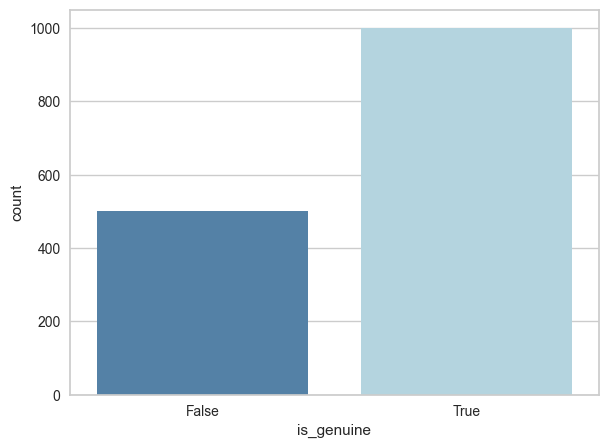

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

palette = ["steelblue", "lightblue"]

plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.countplot(x="is_genuine", data=data, palette=palette, hue="is_genuine", legend=False)

plt.show()

# Machine Learning non supervisé : Clusterisation

### standardisation

In [36]:
data.columns

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'],
      dtype='object')

In [37]:
data_features = data[['diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length']]

In [38]:
X = data_features

# Réduction et centrage de données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pd.DataFrame(X_scaled, columns=X.columns).describe().round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.00,1500.00,1500.00,1500.00,1500.00,1500.00
mean,-0.00,0.00,-0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.01,-2.97,-3.38,-2.28,-3.80,-3.65
25%,-0.68,-0.70,-0.65,-0.69,-0.70,-0.74
50%,0.01,0.03,-0.00,-0.26,-0.05,0.32
75%,0.69,0.67,0.71,0.59,0.68,0.76
max,3.45,2.84,3.16,3.66,3.27,2.02


> **Remarques :** 
> * La moyenne est ramennée à 0
> * La déviation standard est 1

### Réduction de dimensionnalités par ACP

In [39]:
# Import de la fonction PCA depuis Scikit Learn
from sklearn.decomposition import PCA

# Create the PCA model
model_pca = PCA(n_components = 6)

# Fit the model with the standardised data
X_reduced = model_pca.fit_transform(X_scaled)

In [40]:
def display_scree_plot(pca):
    '''Visualisons du scree plot pour PCA'''

    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Nombre de composantes principales")
    plt.ylabel("Variance expliquée en pourcentage")
    plt.title("Scree plot : Eboulis des valeurs propres")
    plt.show(block=False)

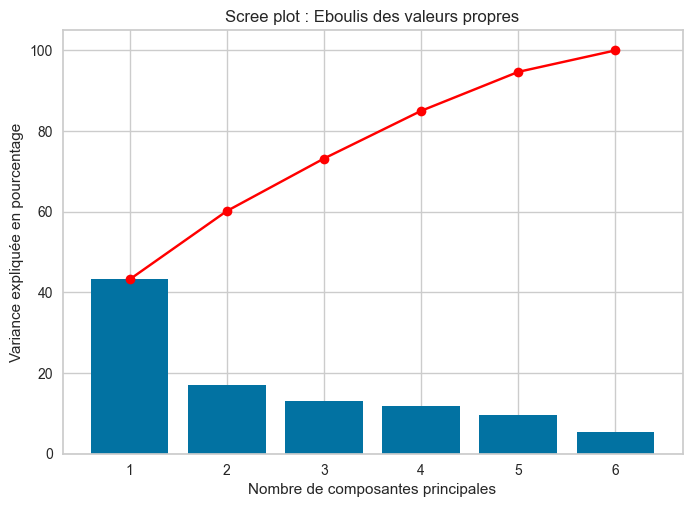

Variance expliquée cumulée : [0.43 0.6  0.73 0.85 0.95 1.  ]


In [41]:
# Scree plot
display_scree_plot(model_pca)

# Explained variance ratio cumsum
print('\033[1m' +"Variance expliquée cumulée :"+'\033[0m', model_pca.explained_variance_ratio_.cumsum().round(2))

# Nombre de composantes à étudier
num_components = 6
pcs = model_pca.components_ 
pc1 = model_pca.components_[0]
pc2 = model_pca.components_[1]
pc3 = model_pca.components_[2]
pc4 = model_pca.components_[3]
pc5 = model_pca.components_[4]
pc6 = model_pca.components_[5]


classed_data = data.copy()
rank_band = [classed_data.loc[note_id, "is_genuine"] for note_id in classed_data.index]
X_projected = model_pca.transform(X_scaled)

## K-Means

### Méthode du coude

  File "c:\Users\diouf\OneDrive\Bureau\ds2\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


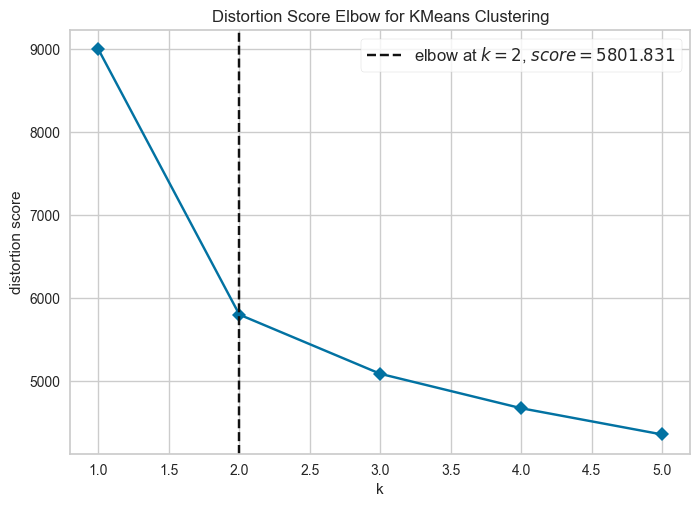

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [42]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Instantiate the clustering model and visualizer
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(1, 6), timings=False)

# Fit the data to the visualizer
visualizer.fit(X_scaled)

# Display the visualizer
visualizer.show()

### Score Silhouette

In [43]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

range_n_clusters = list(range(2, 10))
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, n_init=10) 
    preds = clusterer.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.3434544605493908)
For n_clusters = 3, silhouette score is 0.2106729256626625)
For n_clusters = 4, silhouette score is 0.19628214266380908)
For n_clusters = 5, silhouette score is 0.15616819011714797)
For n_clusters = 6, silhouette score is 0.15118814638476105)
For n_clusters = 7, silhouette score is 0.1431107442254272)
For n_clusters = 8, silhouette score is 0.14270788931281767)
For n_clusters = 9, silhouette score is 0.1406233060412094)


### Algorythme K-means

In [44]:
model_kmeans = KMeans(n_clusters=2,random_state = 0, n_init=10)

model_kmeans.fit_predict(X_scaled)

array([1, 0, 0, ..., 1, 1, 1], dtype=int32)

In [45]:
clusters =  model_kmeans.labels_

# Add the cluster number to the original scaled data
X_clustered = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

X_clustered["cluster"] = clusters

In [46]:
X_clustered.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
0,-0.486540,2.774123,3.163240,0.056419,-1.128325,0.173651,1
1,-1.633729,-2.236535,-0.799668,-1.080642,-0.696799,0.471666,0
2,2.397823,1.504756,-1.291191,-0.125511,-0.912562,0.551901,0
3,-1.961498,-0.399294,0.060498,-1.308054,-0.610494,0.953075,0
4,-0.748754,0.836669,-1.414072,-0.671300,1.417677,-0.158750,0


In [47]:
import joblib

# Enregistrer le modèle KMeans
joblib.dump(model_kmeans, 'model_kmeans.joblib')

['model_kmeans.joblib']

In [48]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [49]:
encoder = LabelEncoder()

def converter(cluster):
    if cluster==True:
        return 1
    else:
        return 0
    
data_kmeans = data.copy()   
data_kmeans['cluster_origin'] = encoder.fit_transform(np.invert(data_kmeans["is_genuine"]))
data_kmeans['cluster_kmeans'] = model_kmeans.labels_


In [50]:
data_kmeans.sample(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster_origin,cluster_kmeans
674,True,172.04,103.94,103.76,3.81,3.24,113.41,0,0
805,True,171.38,103.75,103.16,4.32,3.02,113.25,0,0
540,True,171.96,103.68,103.84,4.46,3.07,112.74,0,0
622,True,171.56,104.32,104.33,3.92,2.97,113.04,0,0
1081,False,171.82,103.90,103.67,4.79,3.36,112.43,1,0


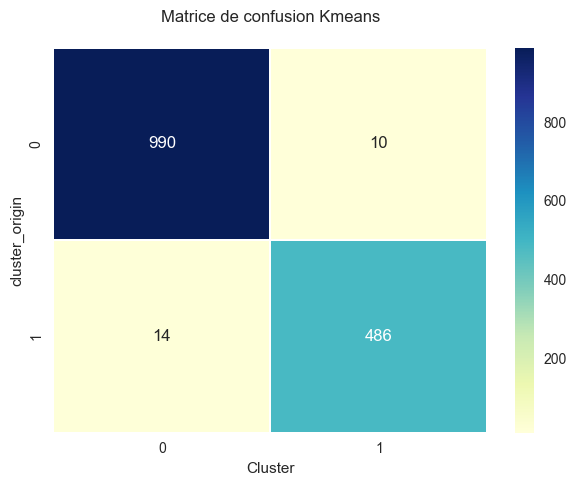

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
conf_matrix = pd.crosstab(data_kmeans['cluster_origin'], model_kmeans.labels_)

# Plot heatmap with customized colors
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt=".3g", linewidths=0.3, cmap="YlGnBu")  
plt.xlabel("Cluster")
plt.title("Matrice de confusion Kmeans\n")
plt.show()

In [52]:
print(metrics.classification_report(data_kmeans['cluster_origin'],data_kmeans['cluster_kmeans']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.98      0.97      0.98       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



### Caractéristiques des centroïdes 

In [53]:
# grouper par cluster avec la moyenne
df_kmeans_clusters = X_clustered.groupby("cluster").mean().round(2).reset_index()
df_kmeans_clusters

,cluster,diagonal,height_left,height_right,margin_low,margin_up,length
0,0,0.10,-0.28,-0.35,-0.55,-0.43,0.59
1,1,-0.19,0.57,0.71,1.12,0.86,-1.20


In [54]:
# Fonction de traçage de coordonnées parallèles
def display_parallel_coordinates_centroids(df, num_clusters):
    '''Affiche un graphique de coordonnées parallèles pour les centroïdes dans df'''

    # Créer le graphique
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Graphique de coordonnées parallèles pour les Centroïdes", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Dessiner le graphique
    parallel_coordinates(df, 'cluster', color=palette)

    # Espacer les axes
    ax = plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)

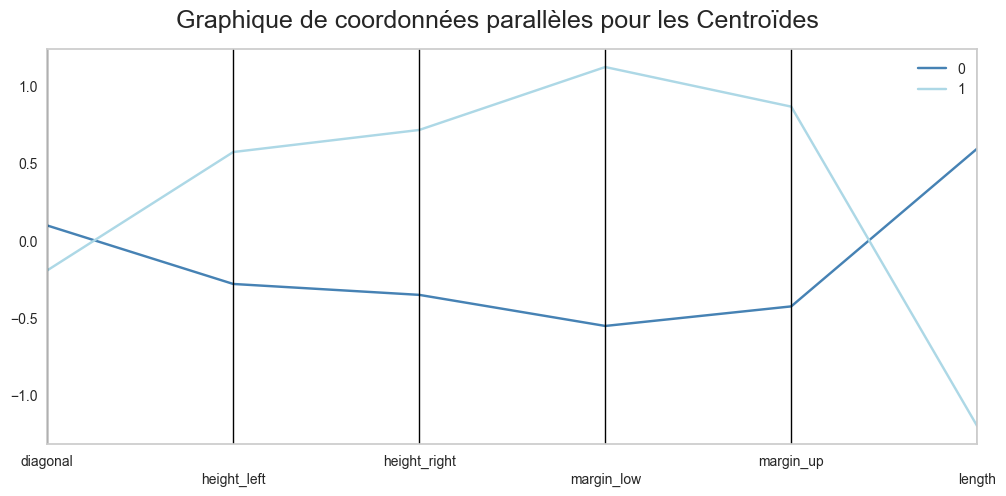

In [55]:
from pandas.plotting import parallel_coordinates
kmeans_ =  X_clustered.groupby(by="cluster").mean()
display_parallel_coordinates_centroids(kmeans_.reset_index(), 5)

# Machine learning supervisé 

## Régression logistique 

In [56]:
# Faire une copie
df = data.copy()
# Afficher les données
df.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16


In [57]:
# Remplacer les données de la colonne "is_genuine"
df["is_genuine"] = df["is_genuine"].astype(int)
# Affichage après remplacement des données
df.sample(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1386,0,172.05,104.22,104.05,5.87,3.18,111.13
442,1,172.03,103.73,104.19,3.75,2.87,112.49
594,1,171.65,103.43,103.83,4.36,3.10,113.53
729,1,171.04,103.84,103.64,4.22,3.36,112.70
649,1,171.59,104.06,103.99,3.93,3.24,112.80


In [58]:
# features
X = df.drop(columns = ["is_genuine"], axis = 1)

# variable cible            
y = df["is_genuine"]   

print(X.shape)
print(y.shape)

(1500, 6)
(1500,)


In [59]:
# Données d'entrainement et de test
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = seed)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1125, 6)
X_test shape: (375, 6)
y_train shape: (1125,)
y_test shape: (375,)


In [60]:
# Standardisation
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

In [61]:
# Instanciation du modèle
lr_model = LogisticRegression(random_state = 42, solver = 'liblinear', multi_class = 'auto')

# Appliquer le modèle (entrainement)
lr_model.fit(X_train, y_train)

LogisticRegression(multi_class='auto', random_state=42, solver='liblinear')

In [62]:
# Prédiction
y_pred = lr_model.predict(X_test)

In [63]:
# Précision globale du modèle
print("Le score sur les données d'entraînement est :", lr_model.score(X_train, y_train))
print("Le score sur les données d'évaluation est :", lr_model.score(X_test, y_test))

Le score sur les données d'entraînement est : 0.992
Le score sur les données d'évaluation est : 0.992


In [64]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       135
           1       0.99      1.00      0.99       240

    accuracy                           0.99       375
   macro avg       0.99      0.99      0.99       375
weighted avg       0.99      0.99      0.99       375



In [65]:
# Visualisation des données de la matrice 
cont_table_rl = pd.crosstab(y_test, y_pred)
cont_table_rl

col_0,0,1
is_genuine,,
0,133,2
1,1,239


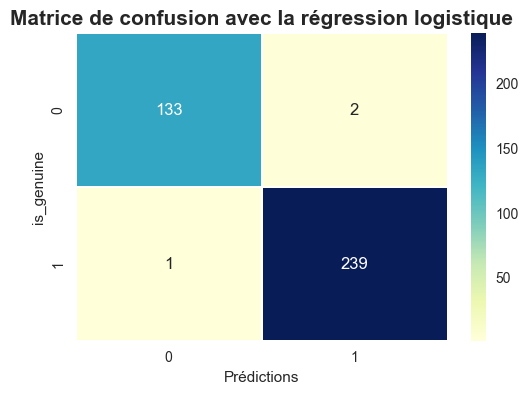

In [66]:
# Visualisation du tableau de contigence
plt.figure(figsize = (6, 4))
sns.heatmap(cont_table_rl, annot = cont_table_rl, fmt=".3g", linewidths=0.3, cmap="YlGnBu")
plt.xlabel("Prédictions")
plt.title("Matrice de confusion avec la régression logistique", fontsize = 15, fontweight = "bold")
plt.plot()
plt.show()

In [67]:
# Sauvegarde du modèle 
import pickle
pickle.dump(lr_model, open("classification_model.pkl", "wb"))

# prédiction sur de nouvelles données

In [68]:
# Chargement du modèle pour faire de nouvelles prédictions
pickle_model_lr = pickle.load(open("classification_model.pkl", "rb"))

In [69]:
# Création de la fonction pour automatiser la production du modèle
def detect_billet(data):
    data_test = data[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']]

    # Standardisation
    scaler = StandardScaler()
    scaler.fit(data_test)
    data_prod = pd.DataFrame(scaler.transform(data_test), columns = data_test.columns)
    # Prédictions
    data_test["prediction"] = pickle_model_lr.predict(data_prod)
    data_test[["proba_faux","proba_vrai"]] = pickle_model_lr.predict_proba(data_prod)
    data_test["authentification"] = pickle_model_lr.predict(data_prod[["diagonal","height_left","height_right","margin_low","margin_up","length"]])
    data_test["authentification"].replace([0,1],["Faux billet", "Vrai billet"], inplace=True)
    
    # Afficher les résultats
    display(data_test)
    print("\n")
    print("Nombre total de billets : ", len(data_test))
    print("Nombre de vrais billets : ", len(data_test[data_test["prediction"] == 1]))
    print("Nombre de faux billets : ", len(data_test[data_test["prediction"] == 0]), "\n")
    
    
    # Visualisation
    labels=["Faux billet", "Vrai billet"]
    sns.countplot(x = "authentification", data = data_test, palette = palette)
    plt.ylabel("Nombre de billets")
    plt.title("Détection du nombre des faux/vrais billets", fontsize = 15, fontweight = "bold")
    plt.show()
    print("\n")

,diagonal,height_left,height_right,margin_low,margin_up,length,prediction,proba_faux,proba_vrai,authentification
0,172.09,103.95,103.73,4.39,3.09,113.19,1,0.000064,0.999936,Vrai billet
1,171.52,104.17,104.03,5.27,3.16,111.82,0,0.897416,0.102584,Faux billet
2,171.78,103.80,103.75,3.81,3.24,113.39,1,0.000031,0.999969,Vrai billet
3,172.02,104.08,103.99,5.57,3.30,111.10,0,0.999674,0.000326,Faux billet
4,171.79,104.34,104.37,5.00,3.07,111.87,0,0.657787,0.342213,Faux billet




Nombre total de billets :  5
Nombre de vrais billets :  2
Nombre de faux billets :  3 



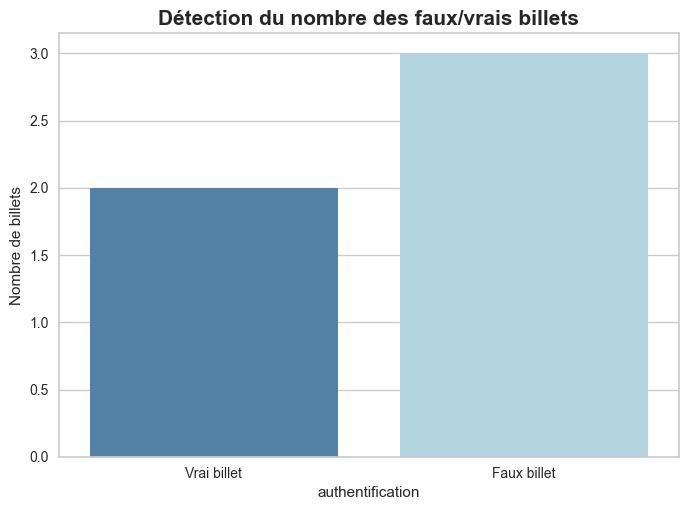

In [70]:
data_production = pd.read_csv('billets_test.csv', sep =",")

data_production = data_production[["diagonal","height_left","height_right","margin_low","margin_up","length"]]

# Appel de la fonction
detect_billet(data_production)

,diagonal,height_left,height_right,margin_low,margin_up,length,prediction,proba_faux,proba_vrai,authentification
0,172.09,103.95,103.73,4.39,3.09,113.19,1,0.000064,0.999936,Vrai billet
1,171.52,104.17,104.03,5.27,3.16,111.82,0,0.897416,0.102584,Faux billet
2,171.78,103.80,103.75,3.81,3.24,113.39,1,0.000031,0.999969,Vrai billet
3,172.02,104.08,103.99,5.57,3.30,111.10,0,0.999674,0.000326,Faux billet
4,171.79,104.34,104.37,5.00,3.07,111.87,0,0.657787,0.342213,Faux billet




Nombre total de billets :  5
Nombre de vrais billets :  2
Nombre de faux billets :  3 



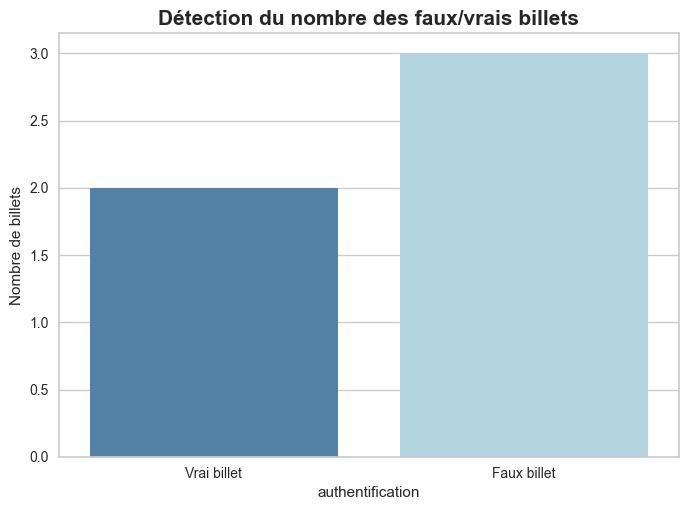

In [71]:
data_final = pd.read_csv('billets_test.csv', sep =",")

data_final = data_final[["diagonal","height_left","height_right","margin_low","margin_up","length"]]

# Appel de la fonction
detect_billet(data_final)

In [72]:
# Sauvegarder le scaler dans un fichier
with open("scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)

print("Scaler sauvegardé dans scaler.pkl")


Scaler sauvegardé dans scaler.pkl
